In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pickle
import math

from architectures.CNN import *

In [2]:
# some constants

LEARNING_RATE = 0.009
BETA1 = 0.5
BATCH_SIZE = 128
EPOCHS = 10
SAVE_SAMPLE_PERIOD = 1
PATH='CNN_test'

task='TRAIN'
#task='TEST'
SEED=1


In [3]:
trunc_normal= tf.truncated_normal_initializer(stddev=1, seed=SEED)
normal = tf.random_normal_initializer(stddev=1, seed=SEED)
uniform = tf.random_uniform_initializer(seed=SEED)

global sizes
sizes = {
        'conv_layer_0': [(8, 8, 2, False, 0.6, lrelu, normal)],
        'maxpool_layer_0':[(4, 2, 1)],
        'conv_layer_1':[(16, 6, 2, False, 0.6, lrelu, normal)],
        'conv_layer_2':[(32, 4, 2, 'bn', 0.6, lrelu, normal)],
        'maxpool_layer_1':[(2, 2, 1)],
        'dense_layers':[(512, 'bn', 0.8, tf.nn.relu, normal),
                       (64, 'bn', 0.8, tf.nn.relu, normal),
                       (32, False, 0.8, tf.nn.relu, normal)],
        'n_classes':10,
        'readout_w_init':uniform
}

In [4]:
#trunc_normal= tf.truncated_normal_initializer(stddev=1, seed=SEED)
#normal = tf.random_normal_initializer(stddev=1, seed=SEED)

#global sizes
#sizes = {
#        'conv_layer_0': [(2, 2, 2, False, 1, lrelu, normal)],
#        'maxpool_layer_0':[(4, 2, 1)],
#        #'conv_layer_1':[(16, 6, 2, False, 1, lrelu, normal)],
#        #'conv_layer_2':[(32, 4, 2, False, 1, lrelu, normal)],
#        #'maxpool_layer_1':[(2, 2, 1)],
#        'dense_layers':[(1, False, 1, tf.nn.relu, normal)],
#        'n_classes':10
#}

In [5]:
def mnist():
    
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

    X_train = mnist.train.images
    Y_train = mnist.train.labels
    
    X_train = X_train.reshape(len(X_train),28,28,1)
    Y_train = Y_train.reshape(len(Y_train),10)
    
    n_H = X_train.shape[1]
    n_W = X_train.shape[2]
    n_C = X_train.shape[-1]
    
    X_test = mnist.test.images
    Y_test = mnist.test.labels
    
    X_test = X_test.reshape(len(X_test),28,28,1)
    Y_test =  Y_test.reshape(len(Y_test),10)
    
    tf.reset_default_graph()
    cnn = CNN(n_H, n_W, n_C, sizes,
              lr=LEARNING_RATE, beta1=BETA1,
              batch_size=BATCH_SIZE, epochs=EPOCHS,
              save_sample=SAVE_SAMPLE_PERIOD, path=PATH, seed=SEED)
    
    vars_to_train= tf.trainable_variables()
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/'+PATH+'.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'.ckpt')
                print('Model restored.')
            
            cnn.set_session(sess)
            cnn.fit(X_train, Y_train, X_test, Y_test)
            
            save_path = saver.save(sess, PATH+'/'+PATH+'.ckpt')
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/'+PATH+'.ckpt')
            print('Model restored.')
            
            cnn.set_session(sess)   
        
        eval_seed=1   
        done = False
        while not done:
            
            np.random.seed(eval_seed)
            i = np.random.choice(len(X_test))
            x = X_test[i].reshape(X_test.shape[1],X_test.shape[2],X_test.shape[3])
            ground_truth=np.where(Y_test[i]>0)[0][0]
            p = cnn.predicted_Y_hat([x]).reshape(sizes['n_classes'])
            prediction = np.where(p==np.max(p))[0][0]
            
            
            plt.clf()
            plt.imshow(x.reshape(
                                X_test.shape[1],
                                X_test.shape[2]),
                                cmap='gray'
                      )
            plt.title('Input image')
            plt.show()
            
            print('True class: '+str(ground_truth)+'\n'+
                  'Predicted class: '+str(prediction)+'\n')
                  
            
            eval_seed+=1
            ans = input("Predict another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Convolutional network architecture detected
Convolution
Input for convolution (?, 28, 28, 1)
Logits shape (?, 10)
Convolution
Input for convolution (?, 28, 28, 1)
Logits shape (?, 10)

 Training...

 ****** 

Training CNN for 10 epochs with a total of 55000 samples
distributed in 429 batches of size 128

The learning rate set is 0.009

 ****** 

Evaluating performance on train/test sets
At epoch 0, train cost: 0.009222, train accuracy 0.3186
test accuracy 0.2984
Evaluating performance on train/test sets
At epoch 1, train cost: 0.005296, train accuracy 0.6927
test accuracy 0.6572
Evaluating performance on train/test sets
At epoch 2, train cost: 0.004532, train accuracy 0.8307
test accuracy 0.8082
Evaluating performance on train/test sets
At epoch 3, train cost: 0.003234, train accuracy 0.8756
tes

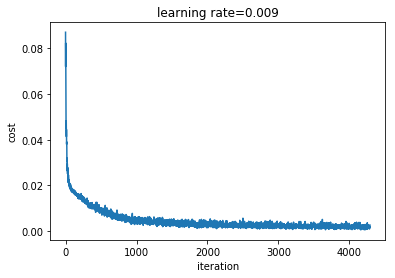

Parameters trained
Model saved in path: CNN_test/CNN_test.ckpt


InvalidArgumentError: You must feed a value for placeholder tensor 'X_test' with dtype float and shape [?,28,28,1]
	 [[Node: X_test = Placeholder[dtype=DT_FLOAT, shape=[?,28,28,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: Softmax/_161 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_142_Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'X_test', defined at:
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-3d0e91404e9b>", line 26, in <module>
    mnist()
  File "<ipython-input-5-a258c268bcbc>", line 26, in mnist
    save_sample=SAVE_SAMPLE_PERIOD, path=PATH, seed=SEED)
  File "/home/hep/davide/NN_toolkit_tf/architectures/CNN.py", line 114, in __init__
    name = 'X_test'
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3091, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'X_test' with dtype float and shape [?,28,28,1]
	 [[Node: X_test = Placeholder[dtype=DT_FLOAT, shape=[?,28,28,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: Softmax/_161 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_142_Softmax", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [6]:
if __name__=='__main__':

    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
    
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)    
        
        mnist()
   
    elif task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            mnist()